In [1]:
# Imports
import torch
from torch import nn
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import cm
print("all modules imported")

all modules imported


In [2]:
# define simple neural network class
class simple_NN(nn.Module):
    def __init__(self):
        super(simple_NN, self).__init__()
        self.linear_tanh_stack = nn.Sequential(
            nn.Linear(1, 16),
            nn.Tanh(),
            nn.Linear(16, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        out = self.linear_tanh_stack(x)
        return out

In [3]:
# create dataset

x_train = torch.tensor([[1.1437e-04],
        [1.4676e-01],
        [3.0233e-01],
        [4.1702e-01],
        [7.2032e-01]], dtype=torch.float32)
y_train = torch.tensor([[1.0000],
        [1.0141],
        [1.0456],
        [1.0753],
        [1.1565]], dtype=torch.float32)

In [4]:
# Initialize the model
model = simple_NN()

# define loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Train
for ep in range(1000):

    # Compute prediction error
    pred = model(x_train)
    loss = loss_fn(pred, y_train)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if ep % 200 == 0:
        print(f"epoch: {ep}, loss: {loss.item():>7f}")

epoch: 0, loss: 0.904694
epoch: 200, loss: 0.000144
epoch: 400, loss: 0.000076
epoch: 600, loss: 0.000023
epoch: 800, loss: 0.000007


In [5]:
# Define the domain where to evaluate the function
domain = [0.0, 1.5]
x_eval = torch.linspace(domain[0], domain[1], steps=100).reshape(-1, 1)
f_eval = model(x_eval)

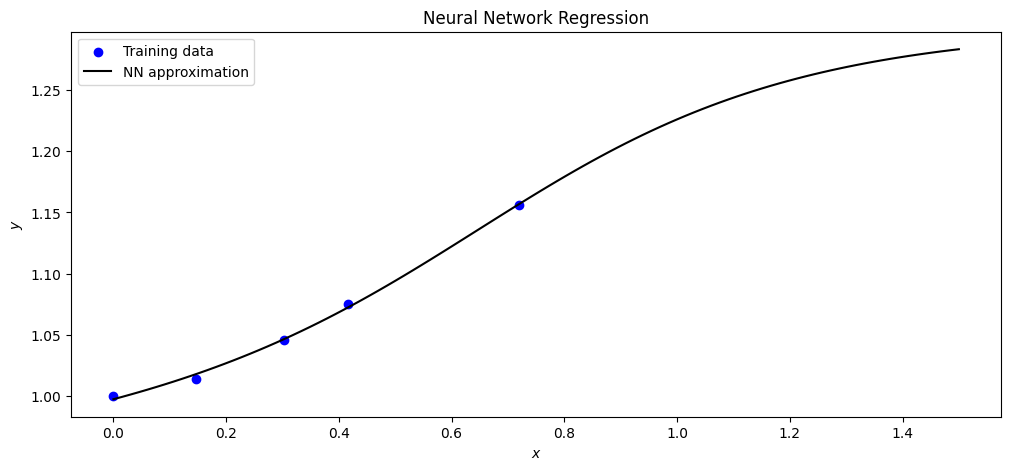

In [6]:
# plotting
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(x_train.detach().numpy(), y_train.detach().numpy(), label="Training data", color="blue")
ax.plot(x_eval.detach().numpy(), f_eval.detach().numpy(), label="NN approximation", color="black")
ax.set(title="Neural Network Regression", xlabel="$x$", ylabel="$y$")
ax.legend();

Starting with PINN

The population growth equation
df(t)/dt = Rt(1-t) is the governing equation
with boundary condition f(t=0) = 1

In [7]:
R = 1.0
ft0 = 1.0
def df(f: simple_NN, x: torch.Tensor, order: int = 1) -> torch.Tensor:
    df_value = f(x)
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            grad_outputs=torch.ones_like(x), # computing gradient of a scalar output w.r.t. input
            create_graph=True,
            retain_graph=True
        )[0]
    return df_value


The neural net needs to satisfy:
dNN(t)/dt - Rt(t-1) = 0 from governing equation
define the loss function as L_PDE = (1/N)sum_1_to_N(dNN/dt-t(1-t))^2 (the MSE of the sum of the mean squared error between the gradient nad the actual expected gradient)

In [8]:
# generate 10 evenly distributed collocation points for training
t = torch.linspace(domain[0], domain[1], steps=10, requires_grad=True).reshape(-1, 1)

define also a loss function L_BC = (NN(t_0)-1)^2 thanks to the boundary condition

The total loss funcition = L_PDE + L_BC + L_data

In [9]:
def compute_loss(model: simple_NN,
                 t: torch.Tensor = None,
                 x: torch.Tensor = None,
                 y: torch.Tensor = None) -> torch.float:
    pde = df(model, t) - R * t * (1 - t)
    pde_loss = pde.pow(2).mean()

    # boundary at t = 0, make sure shape is (1,1) and dtype/device match t
    t0 = torch.tensor([[0.0]], dtype=t.dtype, device=t.device, requires_grad=True)
    bc_pred = model(t0)
    bc_target = torch.tensor([[ft0]], dtype=t.dtype, device=t.device)
    bc_loss = (bc_pred - bc_target).pow(2).mean()

    mse_loss = torch.nn.MSELoss()(model(x), y)

    tot_loss = pde_loss + bc_loss + mse_loss
    return tot_loss

In [10]:
model = simple_NN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

for epoch in range(2000):
    loss = compute_loss(model, t, x_train, y_train)

    #backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"epoch: {epoch}, loss: {loss.item():>7f}")

epoch: 0, loss: 2.416742
epoch: 200, loss: 0.001220
epoch: 400, loss: 0.000604
epoch: 600, loss: 0.000337
epoch: 800, loss: 0.000158
epoch: 1000, loss: 0.000112
epoch: 1200, loss: 0.000101
epoch: 1400, loss: 0.000094
epoch: 1600, loss: 0.000088
epoch: 1800, loss: 0.000087


In [11]:
# numeric solution
def logistic_eq_fn(x, y):
    return R * x * (1 - x)

numeric_solution = solve_ivp(
    logistic_eq_fn, domain, [ft0], t_eval=x_eval.squeeze().detach().numpy()
)

f_colloc = solve_ivp(
    logistic_eq_fn, domain, [ft0], t_eval=t.squeeze().detach().numpy()
).y.T

In [12]:
f_PINN_eval = model(x_eval)

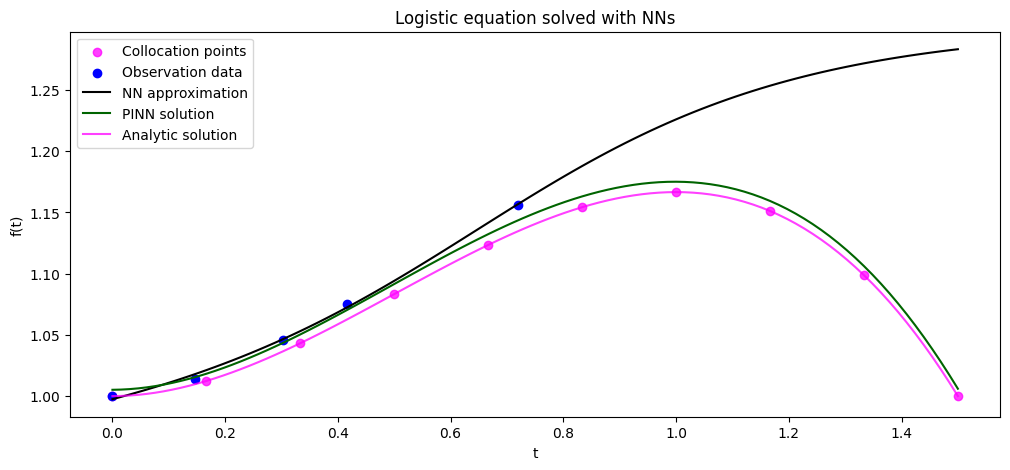

In [13]:
# plotting
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(t.detach().numpy(), f_colloc, label="Collocation points", color="magenta", alpha=0.75)
ax.scatter(x_train.detach().numpy(), y_train.detach().numpy(), label="Observation data", color="blue")
ax.plot(x_eval.detach().numpy(), f_eval.detach().numpy(), label="NN approximation", color="black")
ax.plot(x_eval.detach().numpy(), f_PINN_eval.detach().numpy(), label="PINN solution", color="darkgreen")
ax.plot(x_eval.detach().numpy(), numeric_solution.y.T,
        label="Analytic solution", color="magenta", alpha=0.75)
ax.set(title="Logistic equation solved with NNs", xlabel="t", ylabel="f(t)")
ax.legend();

PINN for a 1d wave
$$d^2f / dx^2 = 1/C * d^2f / dt^2$$

In [14]:
class simple_NN2(nn.Module):
    def __init__(self):
        super(simple_NN2, self).__init__()
        self.linear_tanh_stack = nn.Sequential(
            nn.Linear(2, 16),
            nn.Tanh(),
            nn.Linear(16, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
        )

    def forward(self, x, t):
        x_stack = torch.cat((x, t), dim=1)
        out = self.linear_tanh_stack(x_stack)
        return out

The function we defined before, df(), computes a derivatives of any order w.r.t. only one input variable.
We need to modify it slightly to differentiate w.r.t. both x and t

In [15]:
def df(output: torch.Tensor, input_var: torch.Tensor, order: int = 1) -> torch.Tensor:
    df_value = output
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            input_var,
            grad_outputs=torch.ones_like(input_var), # computing gradient of a scalar output w.r.t. input
            create_graph=True,
            retain_graph=True
        )[0]
    return df_value

In [16]:
def dfdt(model: simple_NN2, x: torch.Tensor, t: torch.Tensor, order: int = 1) -> torch.Tensor:
    output = model(x, t)
    return df(output, t, order = order) # <--- derivative wrt t

In [17]:
def dfdx(model: simple_NN2, x: torch.Tensor, t: torch.Tensor, order: int = 1):
    """Derivative with respect to the spatial variable of arbitrary order"""
    
    f_value = model(x, t)
    return df(f_value, x, order=order) # <--- derivative wrt x

Defining the loss function
$$\mathcal{L}_\text{PDE} = \left( \frac{\partial^2 f}{\partial x^2} - \frac{1}{C} \frac{\partial^2 f}{\partial t^2} \right)^2$$

Boundary conditions:
x_0 = 0, x_1 = 1, both give f(t) = 0
$$\mathcal{L}_\text{BC} = f(x_0, t)^2 + f(x_1, t)^2$$

We also have the known physical condition f(x, 0) = 0.5sin(2 pi x)
$$\mathcal{L}_\text{initF} = \left( f(x, t_0) - \frac{1}{2} \text{sin}(2\pi x) \right)^2$$

Finally, 
$$\mathcal{L}_\text{initDF} = \left( \frac{\partial f}{\partial t} \bigg\rvert_{t=0} \right)^2$$

Total loss is their sum

In [23]:
def initial_condition(x):
    return torch.sin(np.pi * x).reshape(-1,1) * 0.5

def compute_loss(
    model: simple_NN2,
    x: torch.Tensor = None, 
    t: torch.Tensor = None,
    x_idx: torch.Tensor = None, 
    t_idx: torch.Tensor = None,  
    C: float = 1.0,
    device: str = None) -> torch.float:

    # PDE
    pde_loss = dfdx(model, x, t, order=2) - (1/C**2) * dfdt(model, x, t, order=2)

    # boundary conditions
    boundary_x0 = torch.ones_like(t_idx, requires_grad=True).to(device) * x[0]      
    boundary_loss_x0 = model(boundary_x0, t_idx)                                    # f(x0, t)
    boundary_x1 = torch.ones_like(t_idx, requires_grad=True).to(device) * x[-1]    
    boundary_loss_x1 = model(boundary_x1, t_idx)                                    # f(x1, t)
    
    # initial conditions
    f_initial = initial_condition(x_idx)                         # 0.5*sin(2*pi*x)
    t_initial = torch.zeros_like(x_idx)                          # t0
    t_initial.requires_grad = True
    initial_loss_f = model(x_idx, t_initial) - f_initial         # L_initF
    initial_loss_df = dfdt(model, x_idx, t_initial, order=1)     # L_initDF
    
    # obtain the final  loss by averaging each term and summing them up
    final_loss = pde_loss.pow(2).mean() + \
        boundary_loss_x0.pow(2).mean() + \
        boundary_loss_x1.pow(2).mean() + \
        initial_loss_f.pow(2).mean() + \
        initial_loss_df.pow(2).mean()

    return final_loss

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# generate the time-space meshgrid
x_domain = [0.0, 1.0]; n_points_x = 100
t_domain = [0.0, 1.0]; n_points_t = 150
x_idx = torch.linspace(x_domain[0], x_domain[1], steps=n_points_x, requires_grad=True)
t_idx = torch.linspace(t_domain[0], t_domain[1], steps=n_points_t, requires_grad=True)
grids = torch.meshgrid(x_idx, t_idx, indexing="ij")
x_idx, t_idx = x_idx.reshape(-1, 1).to(device), t_idx.reshape(-1, 1).to(device)
x, t = grids[0].flatten().reshape(-1, 1).to(device), grids[1].flatten().reshape(-1, 1).to(device)

# initialize the neural network model
model = simple_NN2().to(device)

In [25]:
# Train
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
for ep in range(3000):

    loss = compute_loss(model, x=x, t=t, x_idx=x_idx, t_idx=t_idx, device=device)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if ep % 300 == 0:
        print(f"epoch: {ep}, loss: {loss.item():>7f}")

epoch: 0, loss: 0.448172
epoch: 300, loss: 0.012384
epoch: 600, loss: 0.000813
epoch: 900, loss: 0.003220
epoch: 1200, loss: 0.000499
epoch: 1500, loss: 0.000180
epoch: 1800, loss: 0.000183
epoch: 2100, loss: 0.000507
epoch: 2400, loss: 0.000442
epoch: 2700, loss: 0.000759


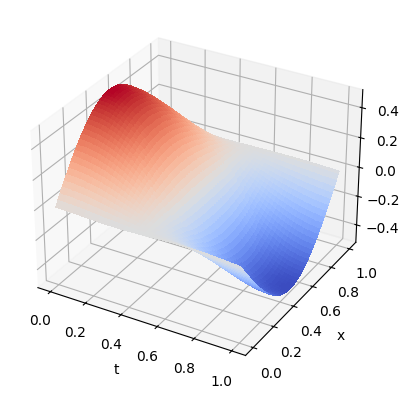

In [27]:
y = model(x, t)
y_np = y.reshape([100,-1]).to("cpu").detach().numpy()

# Plot
X, Y = np.meshgrid(np.linspace(0, 1, 150), np.linspace(0, 1, 100))
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, y_np, linewidth=0, antialiased=False, cmap=cm.coolwarm,)
ax.set_xlabel("t"), ax.set_ylabel("x"), ax.set_zlabel("f")
plt.show();